In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["COHERE_API_KEY"] = "<your-api-key>"
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [4]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=0,
    model="llama3-70b-8192",
)

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
graph_builder.add_node("chatbot", chatbot)

In [9]:
graph_builder.add_edge(START, "chatbot")

In [10]:
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

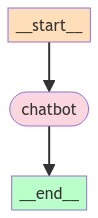

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Namaste Pankaj! It's nice to meet you. How are you doing today?
Assistant: I'm sorry, but I don't know your name. I'm a large language model, I don't have access to personal information about you, and we have just started our conversation. If you'd like to share your name with me, I'd be happy to know it!
Assistant: I apologize, but this is the beginning of our conversation, and we haven't had a previous conversation. I'm happy to chat with you now, though! What would you like to talk about?
Assistant: I apologize, but this is the beginning of our conversation, and I haven't received any previous messages from you. Therefore, I don't have any information about your name. If you'd like to share your name with me, I'd be happy to know it!
Assistant: Namaste Pankaj! It's nice to meet you. How are you doing today?
Assistant: Namaste Pankaj! It's nice to meet you. How are you doing today?
Assistant: I apologize, but this is the beginning of our conversation, and I haven't receive

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://cobusgreyling.substack.com/p/langgraph-from-langchain-explained',
  'content': "Combining LangGraph with LangChain agents, agents can be both directed and cyclic. A Directed Acyclic Graph (DAG) is a type of graph used in computer science and mathematics. Here's a simple explanation: Directed: Each connection (or edge) between nodes (or vertices) has a direction, like a one-way street."}]

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


In [17]:
llm_with_tools = llm.bind_tools(tools)

In [18]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [19]:
llm_with_tools.invoke("What's a 'node' in LangGraph?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_86hx', 'function': {'arguments': '{"query":"LangGraph node"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 949, 'total_tokens': 998, 'completion_time': 0.14, 'prompt_time': 0.160429814, 'queue_time': None, 'total_time': 0.300429814}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a7dd2512-cc10-47df-afe1-be09f21ae9ec-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph node'}, 'id': 'call_86hx'}], usage_metadata={'input_tokens': 949, 'output_tokens': 49, 'total_tokens': 998})

In [20]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("#################################3")
        print(inputs)
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [21]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [22]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

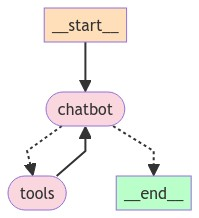

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
#################################3
{'messages': [HumanMessage(content="what's langgraph all about?", id='12ddf8b4-7d37-4187-8cf1-a3aea1a81c49'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_89vx', 'function': {'arguments': '{"query":"langgraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 946, 'total_tokens': 994, 'completion_time': 0.137142857, 'prompt_time': 0.200972181, 'queue_time': None, 'total_time': 0.338115038}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2e7cba1d-8696-4883-8db6-7bb518537832-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'langgraph'}, 'id': 'call_89vx'}], usage_metadata={'input_tokens': 946, 'output_tokens': 48, 'total_tokens': 994})]}
Assistant: [{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph

In [28]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [29]:
graph = graph_builder.compile(checkpointer=memory)

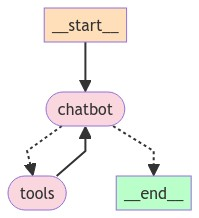

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
config = {"configurable": {"thread_id": "1"}}

In [33]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'thread_ts']